In [21]:
import pandas as pd
from src.data import gedi_pipeline
from src.constants import DATA_PATH, USER_PATH
import seaborn as sns

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.metrics import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
gedi = gedi_pipeline.get_gedi_as_gdp(f"{DATA_PATH}/sierras_unburned_spectral_control_clustering_input.csv")

<Axes: xlabel='pft_class', ylabel='Count'>

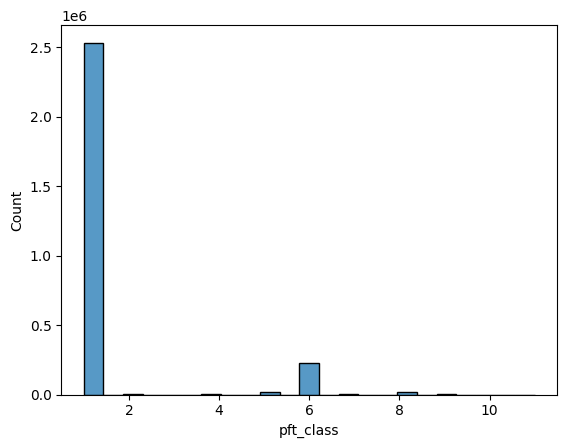

In [7]:
sns.histplot(gedi.pft_class)

In [8]:
gedi.columns

Index(['shot_number', 'longitude', 'latitude', 'agbd', 'agbd_pi_lower',
       'agbd_pi_upper', 'agbd_se', 'beam_type', 'sensitivity', 'pft_class',
       'gedi_year', 'gedi_month', 'absolute_time', 'geometry',
       'burn_severity_median', 'burn_year_median', 'burn_counts_median',
       'time_since_burn', 'elevation', 'slope', 'aspect', 'soil', 'nbr_2018',
       'ndvi_2018', 'SR_B1_2018', 'SR_B2_2018', 'SR_B3_2018', 'SR_B4_2018',
       'SR_B5_2018', 'SR_B6_2018', 'SR_B7_2018', 'nbr_2019', 'ndvi_2019',
       'SR_B1_2019', 'SR_B2_2019', 'SR_B3_2019', 'SR_B4_2019', 'SR_B5_2019',
       'SR_B6_2019', 'SR_B7_2019', 'nbr_2020', 'ndvi_2020', 'SR_B1_2020',
       'SR_B2_2020', 'SR_B3_2020', 'SR_B4_2020', 'SR_B5_2020', 'SR_B6_2020',
       'SR_B7_2020', 'nbr_2021', 'ndvi_2021', 'SR_B1_2021', 'SR_B2_2021',
       'SR_B3_2021', 'SR_B4_2021', 'SR_B5_2021', 'SR_B6_2021', 'SR_B7_2021'],
      dtype='object')

In [22]:
def r_mse(pred,y): return round(math.sqrt(mean_squared_error(y, pred)), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def r_squared(pred, y):
    return r2_score(y, pred)
def m_r2(m, xs, y): return r_squared(m.predict(xs), y)

### Approach 1 - combine all columns

In [53]:
spectral = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ndvi", "nbr"]
years = [2018, 2019, 2020, 2021]
spectral_columns = [f"{x}_{y}" for x in spectral for y in years]
columns_to_use = spectral_columns + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']


In [54]:
df = gedi[columns_to_use]

In [55]:
procs = [Categorify, FillMissing, Normalize]

In [56]:
dep_var = 'agbd'

In [57]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [58]:
splits = RandomSplitter()(range_of(df))

In [59]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [60]:
len(to.train),len(to.valid)


(2245671, 561417)

In [61]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [62]:
m = DecisionTreeRegressor(max_leaf_nodes=10)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=10)

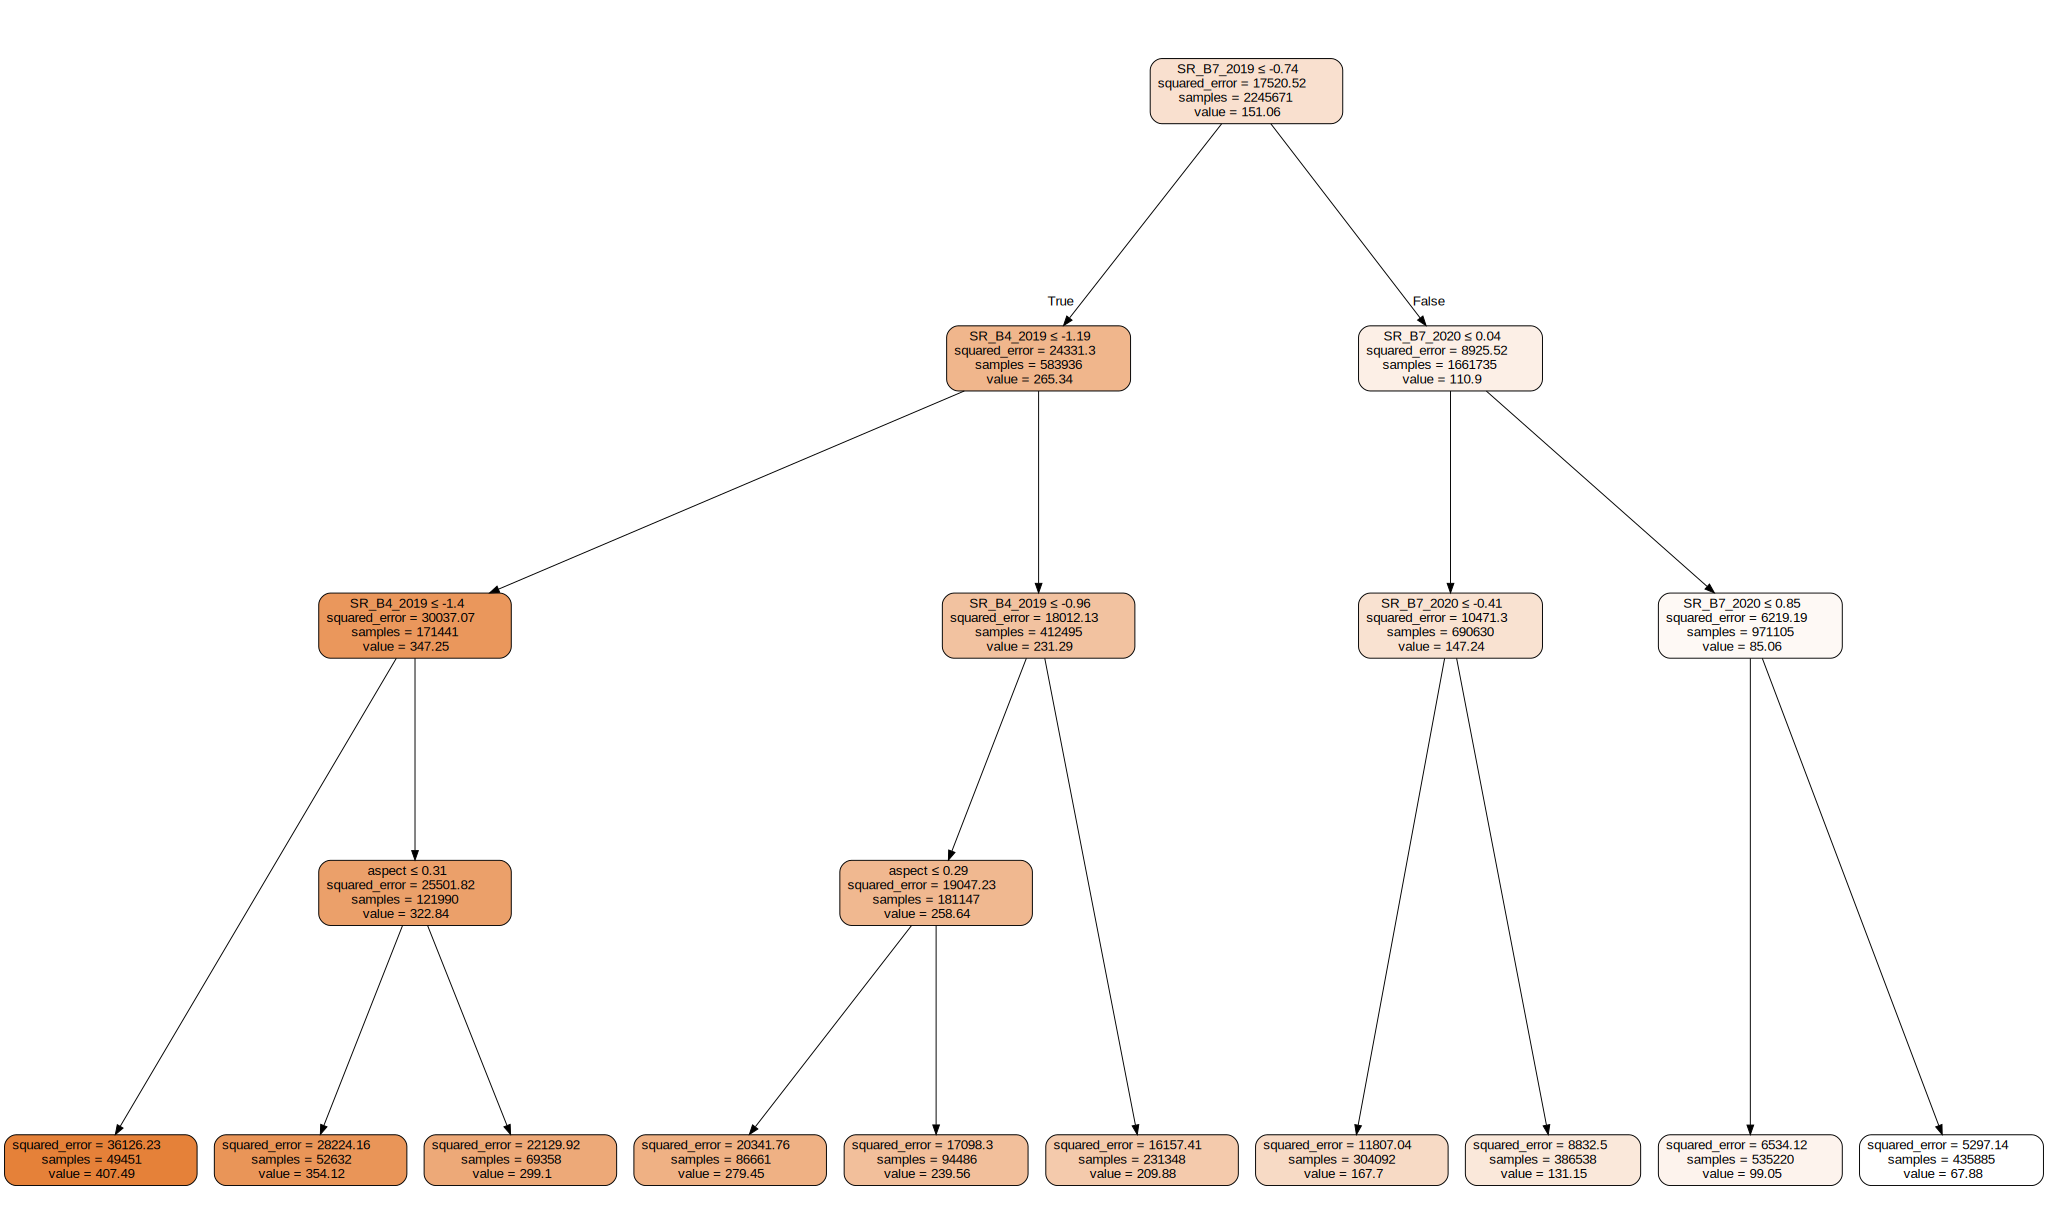

In [25]:
draw_tree(m, xs, size=100, leaves_parallel=True, precision=2)

In [63]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

(104.916517, 104.716423, 0.37110067606029773, 0.3726701414816388)

### Random Forest

In [64]:
def rf(xs, y, n_estimators=100, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [65]:
m = rf(xs, y)

In [66]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

(89.200078, 93.677636, 0.5454058261484546, 0.49796013524031213)

In [67]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/skle

In [36]:
r_mse(preds.mean(0), valid_y)


93.907032

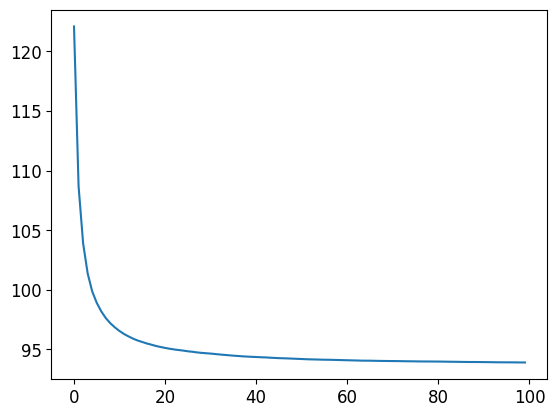

In [38]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(100)])

In [39]:
r_mse(m.oob_prediction_, y)

94.326728

In [40]:
preds_std = preds.std(0)


In [41]:
preds_std[:20]

array([ 47.51002468, 142.26641638,  72.82592666,  70.93397764, 120.30327145,  41.06604094,  46.98247809,  96.70072949,  62.80500051,  39.70351689,  80.72230871,  53.54327615,  70.43569309,
        55.95291411,  81.73877582,  61.36287223,  65.57787052,  27.99994551,  90.20350335, 122.78996954])

In [42]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [68]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
28,SR_B7_2020,0.187010
27,SR_B7_2019,0.141202
15,SR_B4_2019,0.092948
16,SR_B4_2020,0.072096
41,aspect,0.037211
39,elevation,0.029363
40,slope,0.028442
24,SR_B6_2020,0.023368
11,SR_B3_2019,0.021206
29,SR_B7_2021,0.020271


In [71]:
fi[fi.imp>0.02].cols.values

array(['SR_B7_2020', 'SR_B7_2019', 'SR_B4_2019', 'SR_B4_2020', 'aspect', 'elevation', 'slope', 'SR_B6_2020', 'SR_B3_2019', 'SR_B7_2021'], dtype=object)

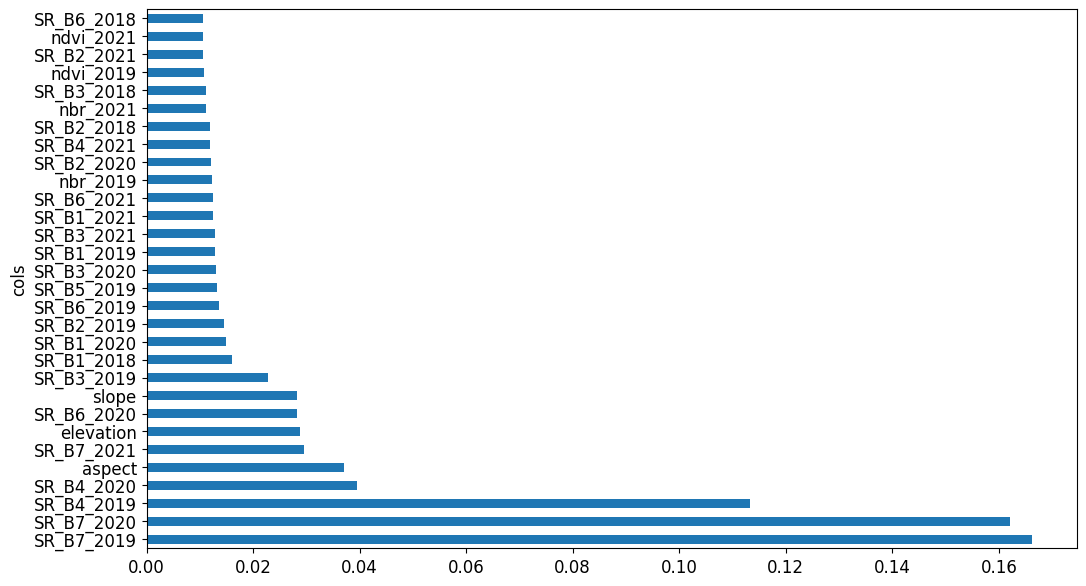

In [44]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [46]:
# Most important variables - B4, B7, aspect, elevation and slope
# TODO: why are 2020 and 2019 the most related --? How are these related to the dates of gedi shots?

<Axes: xlabel='gedi_year', ylabel='Count'>

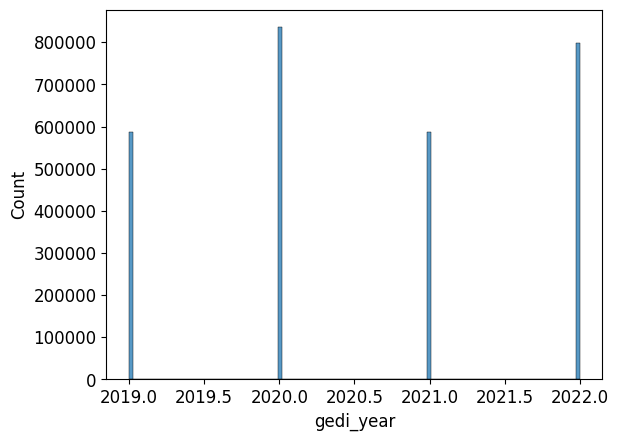

In [47]:
sns.histplot(gedi.gedi_year)

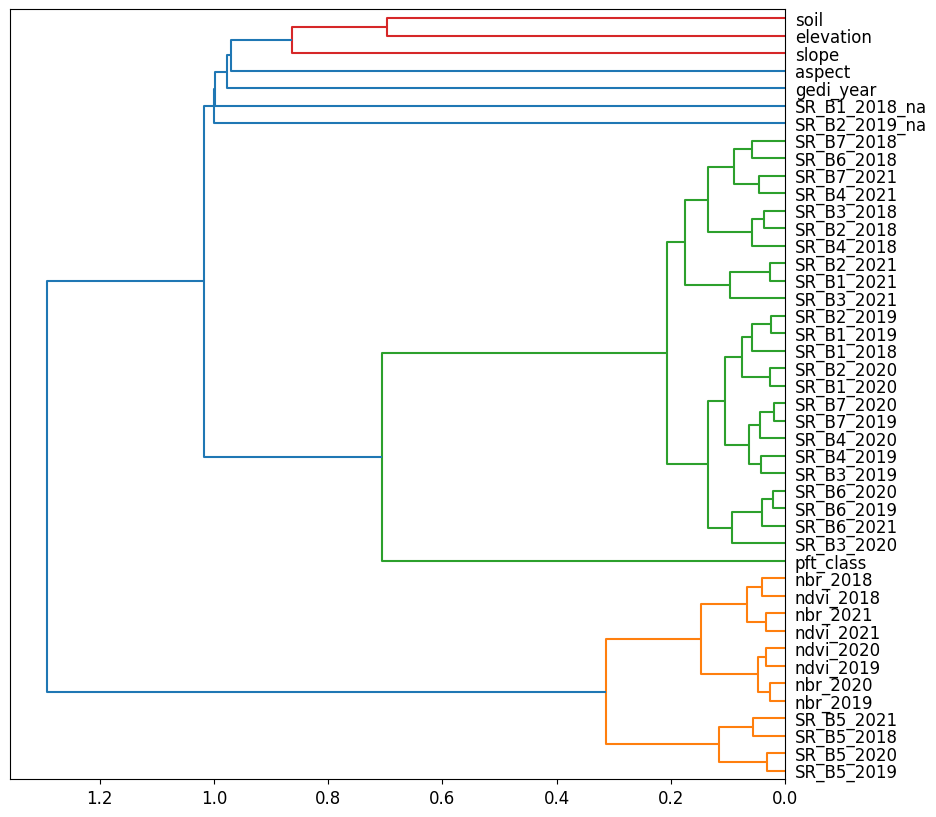

In [72]:
cluster_columns(xs, figsize=(10, 10))


In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

In [78]:
x_2019 = xs[gedi.gedi_year == 2019]
y_2019 = y[gedi.gedi_year == 2019]

/tmp/ipykernel_3830524/1394058293.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [80]:
for year in [2019, 2020, 2021, 2022]:
    print(f'Errors for year: {year}')
    x_2019 = xs[gedi.gedi_year == year]
    y_2019 = y[gedi.gedi_year == year]
    print(m_rmse(m, x_2019, y_2019))
    print(m_r2(m, x_2019, y_2019))

Errors for year: 2019


/tmp/ipykernel_3830524/1872661586.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


87.670179
0.5559491281956741
Errors for year: 2020


/tmp/ipykernel_3830524/1872661586.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


88.740401
0.5566843040844083
Errors for year: 2021


/tmp/ipykernel_3830524/1872661586.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


90.367574
0.5263028093822808
Errors for year: 2022


/tmp/ipykernel_3830524/1872661586.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


89.926773
0.5384153548863296


In [76]:
gedi[gedi.index == 6717337 ]

,shot_number,longitude,latitude,agbd,...,SR_B4_2021,SR_B5_2021,SR_B6_2021,SR_B7_2021
6717337,98010500300181989,-121.731403,40.959701,138.966232,...,9008.491,14727.913,12358.538,10330.169


### Use each year as a separate training piece

In [88]:
gedi_2018 = gedi[[f"{x}_2018" for x in spectral] + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']].rename(columns=dict(zip([f"{x}_2018" for x in spectral], [x for x in spectral])))
gedi_2019 = gedi[[f"{x}_2019" for x in spectral] + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']].rename(columns=dict(zip([f"{x}_2019" for x in spectral], [x for x in spectral])))
gedi_2020 = gedi[[f"{x}_2020" for x in spectral] + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']].rename(columns=dict(zip([f"{x}_2020" for x in spectral], [x for x in spectral])))
gedi_2021 = gedi[[f"{x}_2021" for x in spectral] + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']].rename(columns=dict(zip([f"{x}_2021" for x in spectral], [x for x in spectral])))

In [91]:
gedi_new = pd.concat([gedi_2018, gedi_2019, gedi_2020, gedi_2021])
gedi_new.shape[0], gedi.shape[0]

(11228352, 2807088)

In [94]:
columns_to_use = spectral + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']
df = gedi_new[columns_to_use]

In [95]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [96]:
splits = RandomSplitter()(range_of(df))

In [97]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [98]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [99]:
m = rf(xs, y)

In [100]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

(96.016197, 97.057117, 0.4731301888720142, 0.46168520672890656)

### Training Random Forest only using the data from the year BEFORE gedi

In [101]:
gedi_2019 = gedi[gedi.gedi_year == 2019]
gedi_2020 = gedi[gedi.gedi_year == 2020]
gedi_2021 = gedi[gedi.gedi_year == 2021]
gedi_2022 = gedi[gedi.gedi_year == 2022]

In [105]:
gedi_2019 = gedi_2019.rename(columns=dict(zip([f"{x}_2018" for x in spectral], [x for x in spectral])))
gedi_2020 = gedi_2020.rename(columns=dict(zip([f"{x}_2019" for x in spectral], [x for x in spectral])))
gedi_2021 = gedi_2021.rename(columns=dict(zip([f"{x}_2020" for x in spectral], [x for x in spectral])))
gedi_2022 = gedi_2022.rename(columns=dict(zip([f"{x}_2021" for x in spectral], [x for x in spectral])))

In [106]:
gedi_single_year = pd.concat([gedi_2019, gedi_2020, gedi_2021, gedi_2022])

In [108]:
columns_to_use = spectral + ['agbd', 'pft_class', 'elevation', 'slope', 'aspect', 'soil', 'gedi_year']
df = gedi_single_year[columns_to_use]

In [109]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)


In [110]:
splits = RandomSplitter()(range_of(df))

In [111]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [112]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [113]:
m = rf(xs, y)

In [114]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y), m_r2(m, xs, y), m_r2(m, valid_xs, valid_y)

(92.274427, 96.598695, 0.513195824147294, 0.4676273232799246)

In [116]:
fi = rf_feat_importance(m, xs)
fi[:10].cols.values

array(['SR_B7', 'SR_B6', 'SR_B4', 'elevation', 'aspect', 'SR_B1', 'SR_B2', 'slope', 'SR_B3', 'SR_B5'], dtype=object)

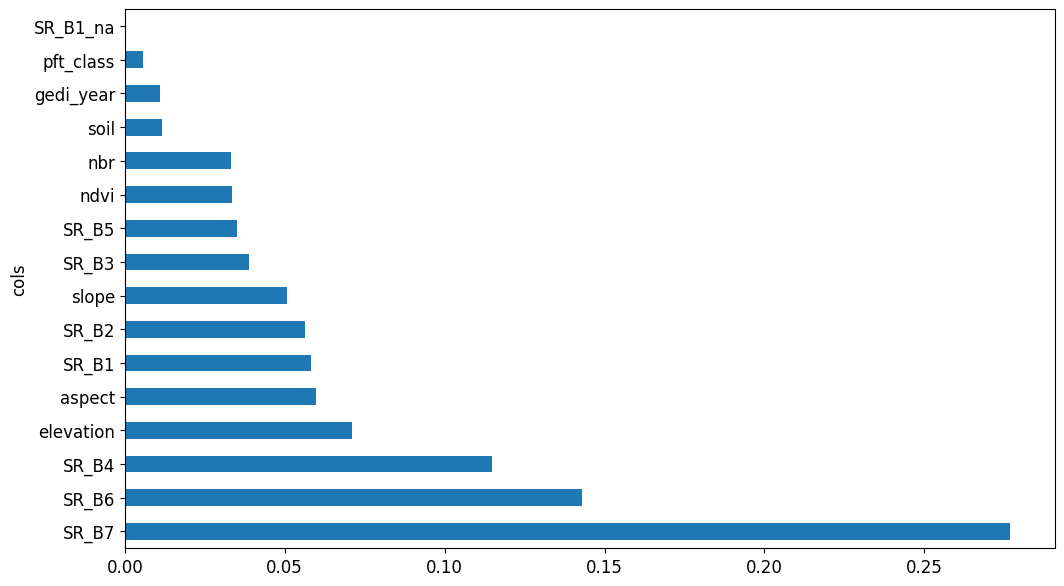

In [117]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);